<a href="https://colab.research.google.com/github/iey704/ComputerVision/blob/main/CV_%EC%B5%9C%EC%A2%851.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* AdamP
* 스케줄러X
* batch=32
* epoch=15
* lr=0.001
   




In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip3 install adamp

  Preparing metadata (setup.py) ... done
  Created wheel for adamp: filename=adamp-0.3.0-py3-none-any.whl size=5981 sha256=d2ade140d352622c8654b8392a413492643b4826a9055e7eae4be13635e37520
  Stored in directory: /root/.cache/pip/wheels/c7/ad/0f/b41b1c45b18c66e5eef5d2254415af8055c7e2b0934145157d
Successfully built adamp


In [3]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor,Normalize, RandomHorizontalFlip, Resize
from torchvision.transforms import RandAugment
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models

from adamp import AdamP
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image,ImageFilter,ImageEnhance

from torch.utils.data import ConcatDataset
from collections import Counter


# 랜덤 시드 설정 공통
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

### GPU Setting ###
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

cuda


In [4]:
### Custom Dataset ###
# Create DataLoader
class CUB2011(Dataset):
  def __init__(self, transform, mode='train'):
    self.mode = mode
    self.transform = transform

    if self.mode == 'train':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets/train')
    elif self.mode == 'valid':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets/valid')
    elif self.mode == 'test':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets/test')

  def __len__(self):
    return len(self.image_folder)

  def __getitem__(self, idx):
    img_path = self.image_folder[idx]
    img = Image.open(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets', self.mode, img_path)).convert('RGB')
    img = self.transform(img)

    label = img_path.split('_')[-1].split('.')[0]
    label = int(label)
    return (img, label)

In [5]:
# Geomentric transform + Visual corruptions
class AddGaussianNoise(object):
    def __init__(self, mean=0, std=1, p=0.5):
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, img):
        if np.random.rand() < self.p:
            img_array = np.array(img)
            noise = np.random.normal(self.mean, self.std, img_array.shape)
            noisy_image = np.clip(img_array + noise, 0, 255)  # Clip values to the range [0, 255]
            return Image.fromarray(noisy_image.astype(np.uint8))
        else:
            return img

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std}, p={self.p})'


class AdjustContrast(object):
    def __init__(self, factor=1.0):
        self.factor = factor

    def __call__(self, img):
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(self.factor)
        return img

    def __repr__(self):
        return self.__class__.__name__ + f'(factor={self.factor})'

class AdjustBrightness(object):
    def __init__(self, factor=1.0):
        self.factor = factor

    def __call__(self, img):
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(self.factor)
        return img

    def __repr__(self):
        return self.__class__.__name__ + f'(factor={self.factor})'


# MIX UP
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size, device=x.device, dtype=torch.long)  # GPU에 있는 x.device를 사용하여 인덱스를 GPU로 전송

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [7]:
### Data Preprocessing & Data Augmentation ###
transforms_train_origin = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),])

transforms_test = transforms.Compose([
    transforms.Resize((448,448)),
    transforms.ToTensor(),])

# 1)Apply RandAugment
transforms_train_rand = transforms.Compose([
    transforms.Resize((448, 448)),
    RandAugment(5,3),
    transforms.ToTensor(),
])
# 2)Geomentric transform + Visual corruptions
transforms_train_g_v = transforms.Compose([
    transforms.Resize((448, 448)),
    #transforms.RandomResizedCrop(448),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(30),
    AddGaussianNoise(mean=0, std=25, p=0.5),  # 가우시안 노이즈를 추가합니다.
    AdjustContrast(factor=2.0),  # 대비를 조절합니다.
    AdjustBrightness(factor=1.5),  # 밝기를 조절합니다.
    transforms.ToTensor(),
])

BATCH_SIZE = 32 # or 64

train_set_origin = CUB2011(mode='train',
                    transform=transforms_train_origin)
val_set = CUB2011(mode='valid',
                  transform=transforms_test)
test_set = CUB2011(mode='test',
                  transform=transforms_test)

# 데이터 증강을 위해 원래 데이터를 복사하고 추가
train_set_augmented = CUB2011(mode='train', transform=transforms_train_rand) # 1)
train_set_augmented2 = CUB2011(mode='train',transform=transforms_train_g_v) # 2)

train_loader = DataLoader(train_set_origin,batch_size=BATCH_SIZE,shuffle=True)

# 3) Mixup된 이미지를 train_loader에 추가
train_set_mixup = []

for input, target in train_loader:
    mixed_input, target_a, target_b, lam = mixup_data(input, target, alpha=1.0)
    train_set_mixup.append((mixed_input, target_a, target_b, lam))

train_set_mixup = transforms.Compose([
    transforms.Resize((448,448)),
    transforms.ToTensor(),])

train_set_mixup = CUB2011(mode='train', transform=train_set_mixup)

# 4) 각 클래스의 샘플 수를 계산
class_counts = Counter([label for _, label in train_set_origin])

# 가장 작은 클래스의 샘플 수를 찾아 minority_class_label로 지정
minority_class_label = min(class_counts, key=class_counts.get)

# Create a new dataset from replicated_data
replicated_data = CUB2011(mode='train', transform=transforms_train_rand)
replicated_data.image_folder = [data for data in train_set_origin.image_folder if data[1] == minority_class_label]


# 다 합친거
train_set_combined = ConcatDataset([train_set_origin,#replicated_data,
                                    train_set_augmented,train_set_augmented2,train_set_mixup])

print('Num of each dataset: ',len(train_set_combined),len(val_set),len(test_set))

# Dataloader class는 bath기반의 딥러닝모델 학습을 위해서 mini batch를 만들어주는 역할을 한다
# dataloader를 통해 dataset의 전체 데이터가 batch size로 나뉘게 된다
train_loader = DataLoader(train_set_combined, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set,batch_size=BATCH_SIZE,shuffle=False)
test_loader = DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=False)

print("Loaded dataloader")

Num of each dataset:  9440 296 298
Loaded dataloader


/////////////여기는  plot하는 부분이라 건너뛰셈

Batch 1


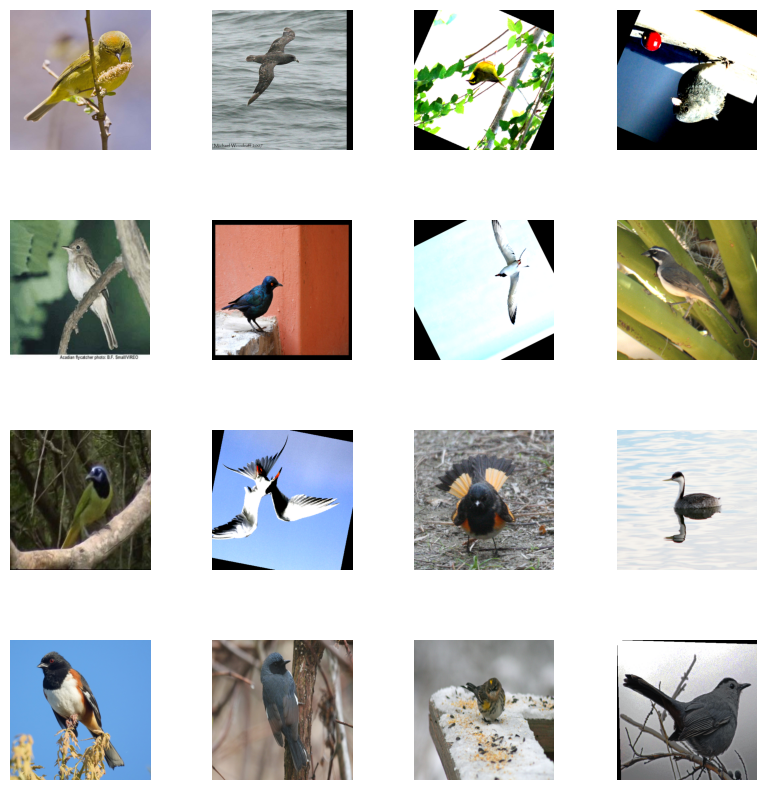

Batch 2


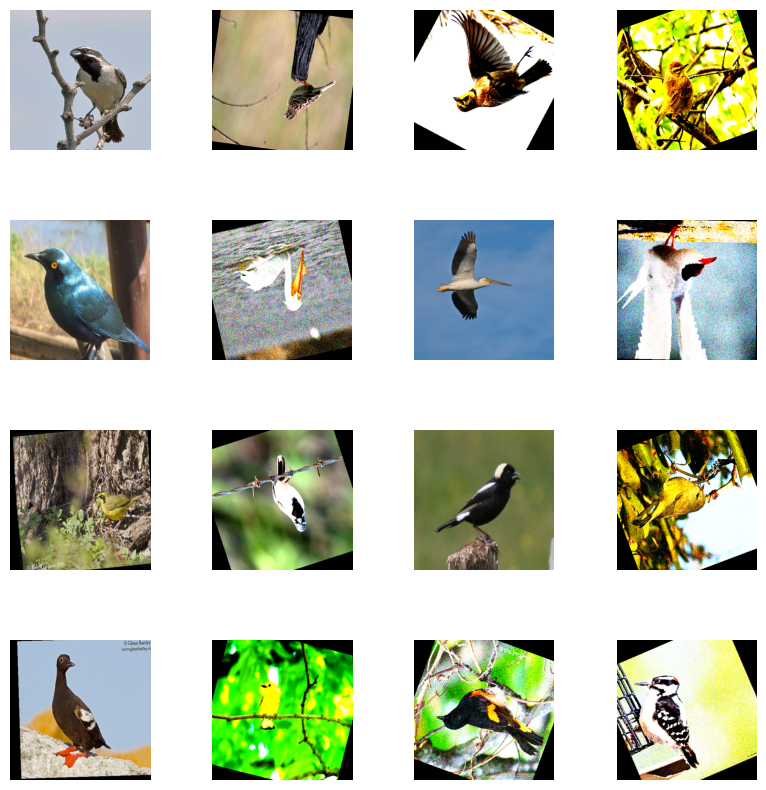

Batch 3


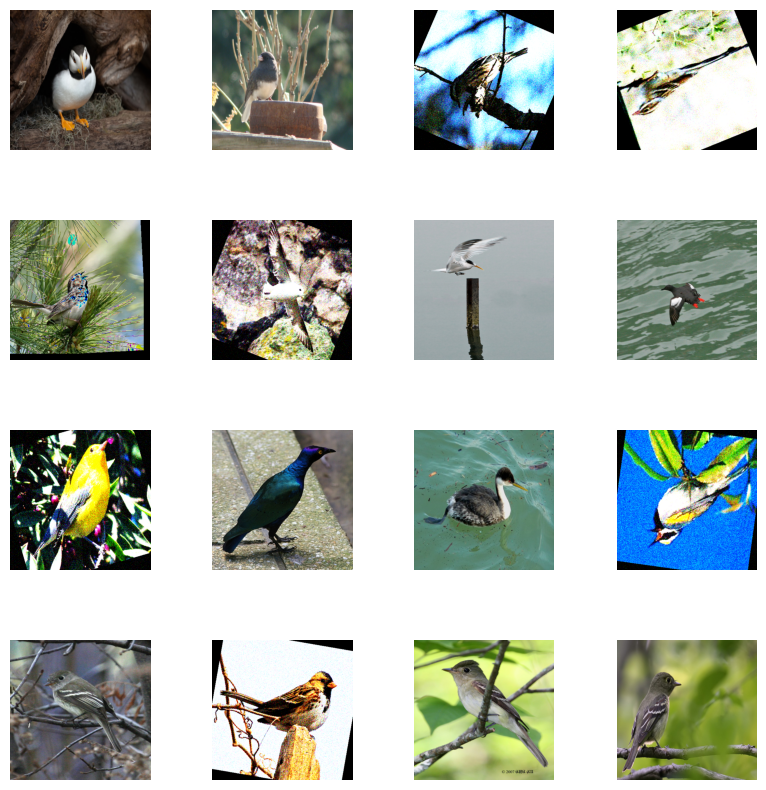

In [8]:
# Define the number of rows and columns for the grid
num_rows = 4  # You can change this to the desired number of rows
num_cols = 4  # You can change this to the desired number of columns

# Function to unnormalize and display a grid of images
def imshow_grid(images, num_rows, num_cols):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < len(images):
                img = images[index]
                npimg = img.numpy()
                ax = axes[i, j]
                ax.imshow(np.transpose(npimg, (1, 2, 0)))
                ax.axis('off')

    plt.show()

# Iterate through the train_loader
for batch_idx, (images, labels) in enumerate(train_loader):
    if batch_idx >= 3:
        break  # Stop after visualizing the specified number of batches

    print(f"Batch {batch_idx + 1}")
    imshow_grid(images, num_rows, num_cols)  # Display the grid of images


KeyboardInterrupt: ignored

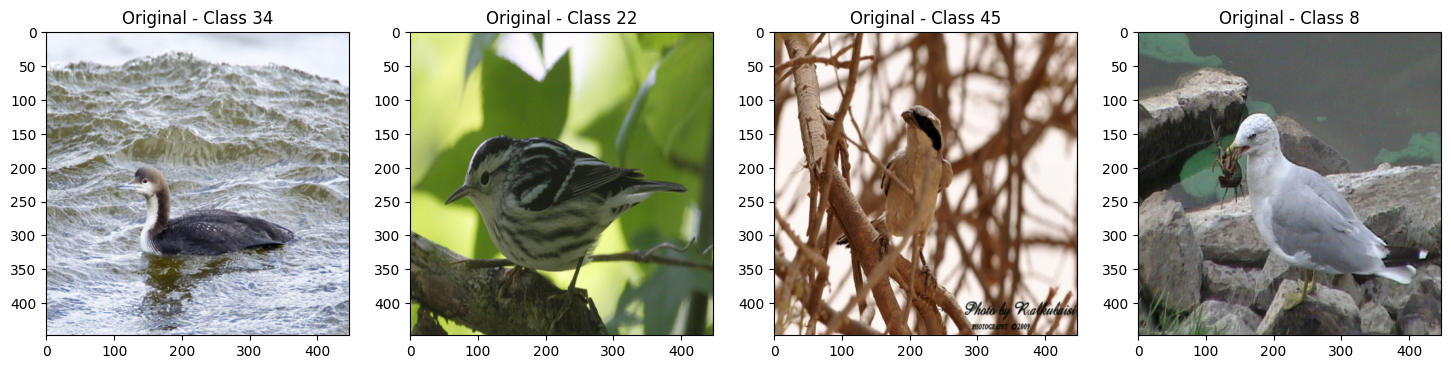

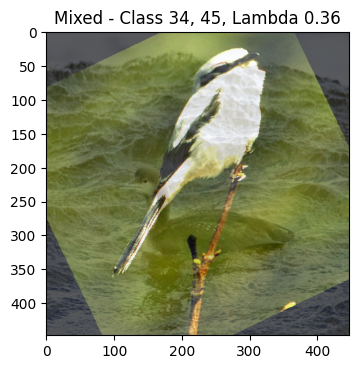

In [9]:
# Mixup된 이미지를 표시
def imshow(inp, title=None):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# 데이터 로더에서 몇 개의 배치를 가져와 Mixup을 적용하고 이미지를 표시
for i, (inputs, targets) in enumerate(train_loader):
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    mixed_inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha=1.0)

    plt.figure(figsize=(18, 18))
    for j in range(4):  # 처음 4개 이미지만 표시
        plt.subplot(1, 4, j + 1)
        imshow(inputs[j])
        plt.title(f"Original - Class {targets[j]}")

    plt.figure(figsize=(18, 18))
    for j in range(4):  # 처음 4개 이미지만 표시
        plt.subplot(1, 4, j + 1)
        imshow(mixed_inputs[j])
        plt.title(f"Mixed - Class {targets_a[j]}, {targets_b[j]}, Lambda {lam:.2f}")

    if i == 3:  # 예시로 4개의 배치만 표시
        break

plt.show()

여기는  plot하는 부분이라 건너뛰셈 ////////////

In [10]:
# 스케줄러 사용
from torch.optim.lr_scheduler import CosineAnnealingLR

### Model / Optimizer ###
EPOCH = 15
lr = 0.001

model = models.resnet18(pretrained=True)

### Tranfer Learning ###
num_features = model.fc.in_features
model.fc = nn.Linear(num_features,50)
'''
model.fc = nn.Sequential(
    nn.Linear(num_features,256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 50)  # 클래스 수에 맞게 조정
)#선택
'''
model.to(DEVICE)

optimizer = AdamP(model.parameters(),lr=lr,betas=(0.9, 0.999))

# 스케줄러 초기화 (주기와 최소/최대 학습률 설정)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0.001)

print("Created a learning model and optimizer")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s]


Created a learning model and optimizer


In [11]:
### Train/Evaluation ###
def train(model,train_loader,optimizer,epoch):
  model.train()
  for i,(image,target) in enumerate(train_loader):
    image,target = image.to(DEVICE),target.to(DEVICE)
    output = model(image)
    optimizer.zero_grad()
    # loss func을 어떤 것을 사용할 것인지?
    train_loss = F.cross_entropy(output,target).to(DEVICE)

    train_loss.backward()
    optimizer.step()

    # 스케줄러 업데이트
    #scheduler.step()

    if i%10 ==0:
      print(
          f'Train Epoch: {epoch} [{i}/{len(train_loader)}]\tloss: {train_loss.item():6f}')

  return train_loss

def evaluate(model,val_loader):
  model.eval()
  eval_loss = 0
  correct = 0
  with torch.no_grad():
    for i,(image,target) in enumerate(val_loader):
      image,target = image.to(DEVICE),target.to(DEVICE)
      output = model(image)

      eval_loss += F.cross_entropy(output,target, reduction='sum').item()
      pred = output.max(1,keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()

  eval_loss /= len(val_loader.dataset)
  eval_accuracy = 100*correct / len(val_loader.dataset)
  return eval_loss,eval_accuracy

In [12]:
### Main ###
start = time.time()
best = 0
train_losses = []  # 훈련 손실을 저장할 목록
val_losses = []    # 검증 손실을 저장할 목록
val_accuracys = []

for epoch in range(EPOCH):
  train_loss = train(model,train_loader,optimizer,epoch)
  val_loss,val_accuracy = evaluate(model,val_loader)

  # 훈련 및 검증 손실을 목록에 추가
  train_losses.append(train_loss)
  val_losses.append(val_loss)

  # Save best model
  if val_accuracy > best:
    best = val_accuracy
    torch.save(model.state_dict(),"./best_model.pth")

  val_accuracys.append(val_accuracy)
  print(f"[{epoch}]Validation Loss: {val_loss:.4f},Accuracy: {val_accuracy:.4f}%")

# Test result
test_loss,test_accuracy = evaluate(model,test_loader)
print(f'[FINAL] Test Loss: {test_loss:.4f},Accuracy: {test_accuracy:.4f}%')

end = time.time()
elasped_time = end - start

print("Best Accuracy: ",best)
print(
    f"Elasped Time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")
print(
    f"time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")


Train Epoch: 0 [0/295]	loss: 4.193702
Train Epoch: 0 [10/295]	loss: 3.911609
Train Epoch: 0 [20/295]	loss: 3.557198
Train Epoch: 0 [30/295]	loss: 3.207404
Train Epoch: 0 [40/295]	loss: 3.042412
Train Epoch: 0 [50/295]	loss: 2.903867
Train Epoch: 0 [60/295]	loss: 2.483762
Train Epoch: 0 [70/295]	loss: 2.244692
Train Epoch: 0 [80/295]	loss: 2.447666
Train Epoch: 0 [90/295]	loss: 2.466940
Train Epoch: 0 [100/295]	loss: 2.437989
Train Epoch: 0 [110/295]	loss: 1.899627
Train Epoch: 0 [120/295]	loss: 2.114412
Train Epoch: 0 [130/295]	loss: 2.104628
Train Epoch: 0 [140/295]	loss: 1.811612
Train Epoch: 0 [150/295]	loss: 1.811779
Train Epoch: 0 [160/295]	loss: 1.761360
Train Epoch: 0 [170/295]	loss: 1.880477
Train Epoch: 0 [180/295]	loss: 1.745744
Train Epoch: 0 [190/295]	loss: 1.462236
Train Epoch: 0 [200/295]	loss: 2.140239
Train Epoch: 0 [210/295]	loss: 1.359968
Train Epoch: 0 [220/295]	loss: 1.723399
Train Epoch: 0 [230/295]	loss: 1.576757
Train Epoch: 0 [240/295]	loss: 1.303942
Train Epoch

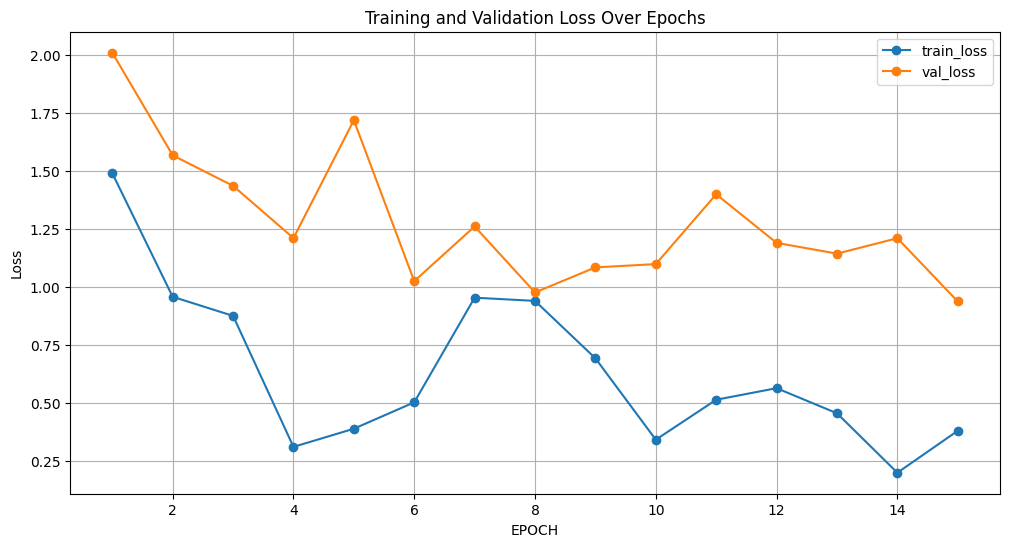

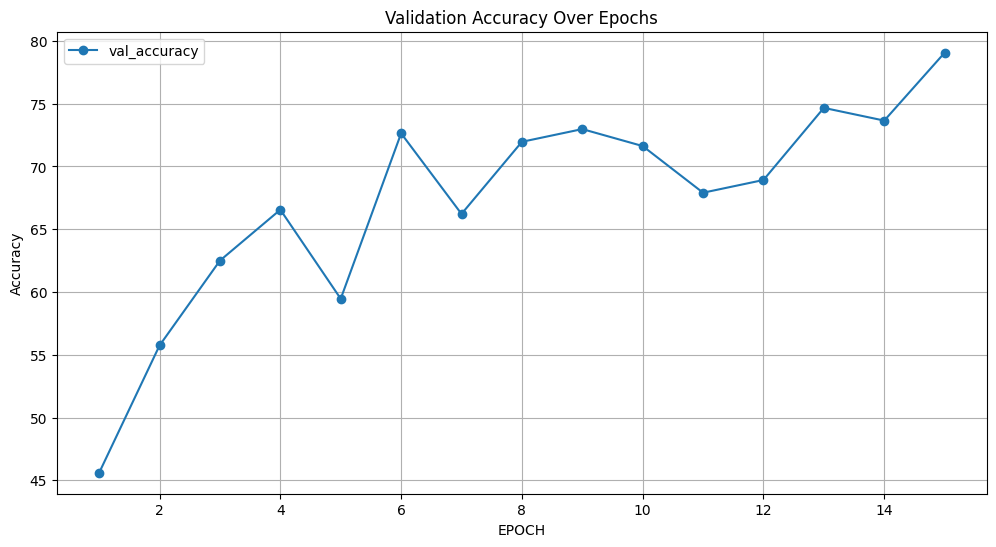

In [13]:
# 이제 손실 값을 플로팅합니다.
import matplotlib.pyplot as plt

# train_loss와 val_loss 텐서를 CPU로 이동하고 NumPy 배열로 변환
train_losses = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]

plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCH + 1), train_losses, label='train_loss', marker='o')
plt.plot(range(1, EPOCH + 1), val_losses, label='val_loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')

plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


val_accuracys = [acc.cpu().detach().numpy() if isinstance(acc, torch.Tensor) else acc for acc in val_accuracys]
plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCH + 1), val_accuracys, label='val_accuracy', marker='o')
plt.title('Validation Accuracy Over Epochs')

plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()